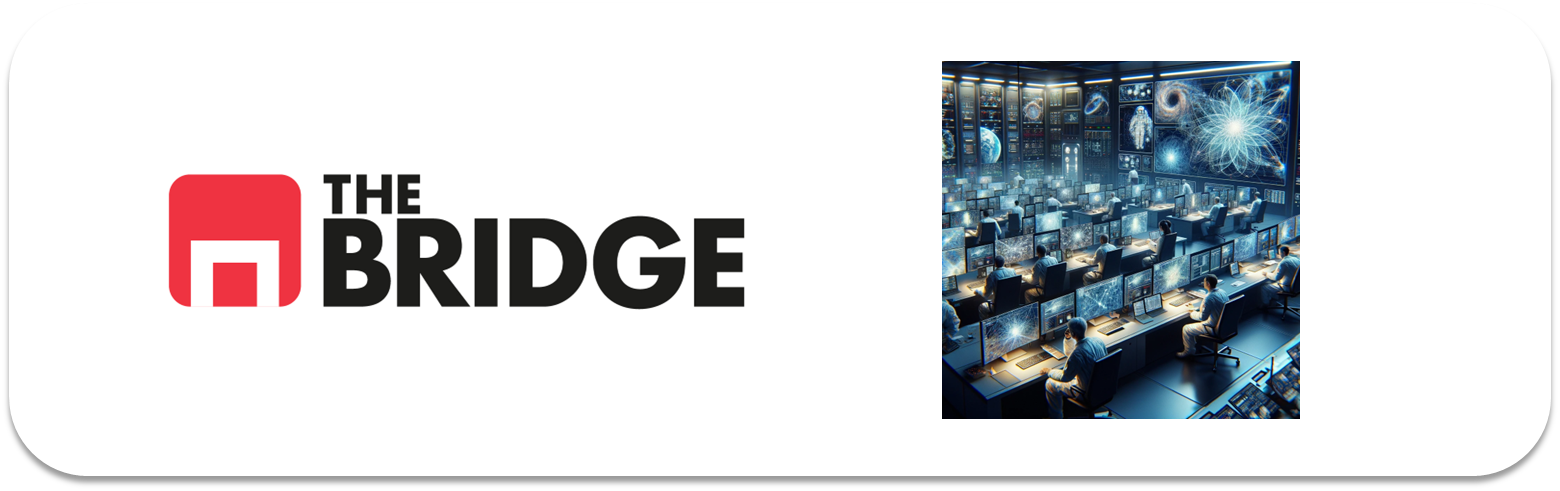

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import cv2
import tensorflow as tf
import keras



from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

In [2]:

TRAIN_PATH = "./data/seg_train/"
TEST_PATH = "./data/seg_test/"

IMG_WIDTH = IMG_HEIGHT = 75

In [15]:
def read_data(directorio, reshape_dim = (IMG_WIDTH,IMG_HEIGHT)):
    X = [] 
    y = []
    supported_extensions = (".jpg", ".jpeg", ".png")  # Extensiones soportadas
    
    for folder in os.listdir(directorio):
        folder_path = os.path.join(directorio, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(supported_extensions):
                    file_path = os.path.join(folder_path, file)
                    image = imread(file_path)
                    if image is not None:
                        image = cv2.resize(image, reshape_dim)  # Redimensionamos las imágenes
                        if image.shape == (*reshape_dim, 3):  # Asegurarse de que la imagen tiene 3 canales
                            X.append(image / 255.0)
                            y.append(folder)
                        else:
                            print(f"Imagen {file_path} no tiene las dimensiones correctas: {image.shape}")
                    else:
                        print(f"No se pudo leer la imagen {file_path}")
    return np.array(X), np.array(y)

def show_images_batch(paisajes, names=[], n_cols=5, size_scale=2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap="Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [16]:
X_train,y_train = read_data(TRAIN_PATH, (IMG_WIDTH, IMG_HEIGHT))
X_test, y_test = read_data(TEST_PATH, (IMG_WIDTH, IMG_HEIGHT))

In [26]:
from sklearn.preprocessing import LabelEncoder
# Convertir etiquetas a valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [27]:
# Verificar formas de datos
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (14034, 75, 75, 3), y_train shape: (14034,)
X_test shape: (3000, 75, 75, 3), y_test shape: (3000,)


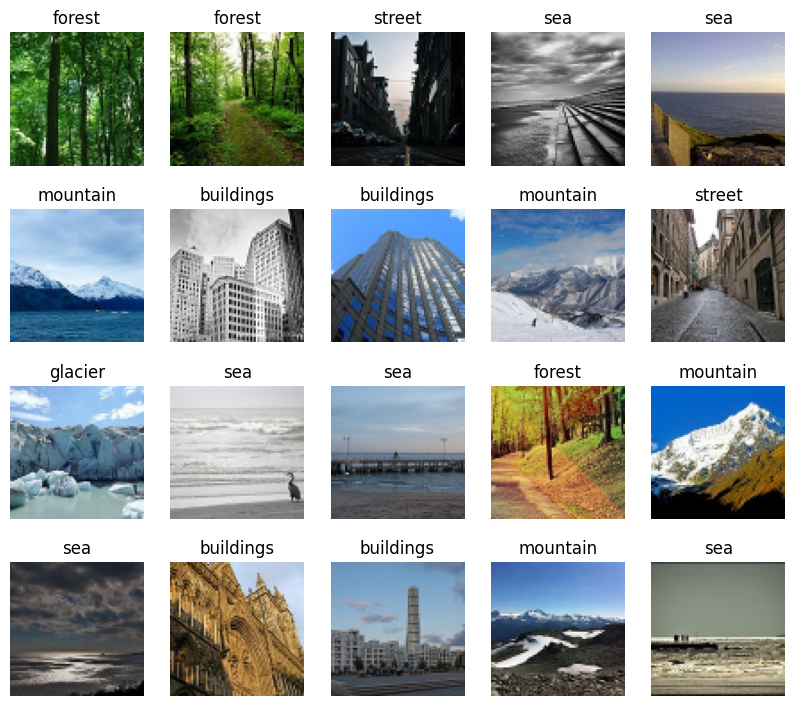

In [18]:
#pintado de imagenes
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [19]:
#MiniEDA
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [20]:
X_train.size #es muy demasiado grande

236823750

In [38]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))



C:\Users\Usuario\AppData\Local\Temp\ipykernel_16760\3839853369.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [39]:
#Para poder mejorar la generalización del modelo vamos a emplear aumentado de imágenes:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=20)
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=20)

In [40]:
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # Cambiar a 'softmax' y ajustar el número de clases
                                                # La capa de salida tiene 6 unidades con activación softmax, lo cual es apropiado para un problema de clasificación con 6 clases

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
# La función de pérdida utilizada es SparseCategoricalCrossentropy, que es apropiada para etiquetas enteras.

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 38, 38,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 38, 38,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 38, 38,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 38, 38,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 38, 38,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 38, 38,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 38, 38,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 38, 38,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 38, 38,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 39, 39,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 19, 19,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 19, 19,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 19, 19,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 19, 19,    │      2,304 │ block_1_depthwis

 Total params: 2,430,598 (9.27 MB)

 Trainable params: 172,614 (674.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
# Entrenamiento del modelo
history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=10)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.1827 - loss: 1.8148 - val_accuracy: 0.1700 - val_loss: 1.7968
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.1765 - loss: 1.7966 - val_accuracy: 0.1673 - val_loss: 1.7965
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.1820 - loss: 1.7945 - val_accuracy: 0.1457 - val_loss: 1.7945
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.1807 - loss: 1.7955 - val_accuracy: 0.1670 - val_loss: 1.7896
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.1609 - loss: 1.7923 - val_accuracy: 0.1407 - val_loss: 1.7891
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.1979 - loss: 1.7881 - val_accuracy: 0.1750 - val_loss: 1.7897
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.1767 - loss: 1.7917 - val_accuracy: 0.1750 - val_loss: 1.7853
Epoch 8/10
  2/100 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.1000 - loss: 1.8

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.1490 - loss: 1.7962 - val_accuracy: 0.1750 - val_loss: 1.7851
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.1840 - loss: 1.7911 - val_accuracy: 0.1750 - val_loss: 1.7831
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.1821 - loss: 1.7909 - val_accuracy: 0.1843 - val_loss: 1.7901


5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [42]:
# Fine-Tuning del modelo
base_model.trainable = True

In [43]:
# Recompilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [44]:
history_fine = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=10)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 653ms/step - accuracy: 0.1753 - loss: 1.8677 - val_accuracy: 0.1643 - val_loss: 1.7924
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - accuracy: 0.2054 - loss: 1.8150 - val_accuracy: 0.1700 - val_loss: 1.7988
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 463ms/step - accuracy: 0.2537 - loss: 1.7300 - val_accuracy: 0.1580 - val_loss: 1.7983
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 483ms/step - accuracy: 0.3177 - loss: 1.6630 - val_accuracy: 0.1577 - val_loss: 1.8043
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.3628 - loss: 1.6100 - val_accuracy: 0.1693 - val_loss: 1.8171
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 557ms/step - accuracy: 0.3743 - loss: 1.5629 - val_accuracy: 0.1580 - val_loss: 2.0287
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.4247 - loss: 1.4897 - val_accuracy: 0.1580 - val_loss: 2.0605
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.2753 - loss: 1

In [45]:
# Evaluación y comparación
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

#esto ha salido mu malamente :')

150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.1556 - loss: 1.7964
Loss: 1.7965234518051147, Accuracy: 0.16433332860469818


In [46]:
# Mostrar matriz de confusión y reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir predicciones a clases
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step
[[  0  13   0  19   2 403]
 [  0  19   0  23   5 427]
 [  0  43   0  37   0 473]
 [  0  15   0  40   5 465]
 [  0  12   0  34   2 462]
 [  0  19   0  30   2 450]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.16      0.04      0.06       474
           2       0.00      0.00      0.00       553
           3       0.22      0.08      0.11       525
           4       0.12      0.00      0.01       510
           5       0.17      0.90      0.28       501

    accuracy                           0.17      3000
   macro avg       0.11      0.17      0.08      3000
weighted avg       0.11      0.17      0.08      3000



c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

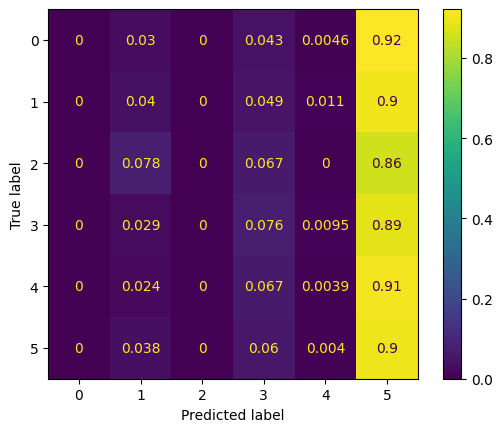

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, normalize="true")

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.